In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from kmapper import jupyter

import numpy as np
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from scipy.linalg import svd
from numpy import linalg as LA
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import pickle
import pandas as pd
from random import randint
import umap
import kmapper as km
import networkx as nx
from community import best_partition # this is not part of networkx
import os.path

def convertNansToZeros(ma):
    nan_elements = np.flatnonzero(np.isnan(ma.data))
    if len(nan_elements) > 0:
        ma.data[nan_elements] = 0
    return ma


def convertInfsToZeros(ma):
    inf_elements = np.flatnonzero(np.isinf(ma.data))
    if len(inf_elements) > 0:
        ma.data[inf_elements] = 0
    return ma

def usvd(df):
    data = df.fillna(0).values
    '''rescale observed data to (-1,1) range and output the new matrix z'''
    i = np.nonzero(data)[0]
    j = np.nonzero(data)[1]
    x = data[np.nonzero(data)]
    a = x.min()
    b = x.max()
    x = (x - (a+b)*0.5)/((b-a)*0.5)
    z = csc_matrix((x,(i,j)), data.shape).todense()
    '''svd'''
    u, s, vt = svd(z,check_finite=True,full_matrices=False)
    '''truncate svd'''
    p = np.count_nonzero(z)*1.0/z.size # probability estimated from data pattern
    threshold = 2.01*np.sqrt(p*max(z.shape)) # threshold obtained by usvd paper
    ix = np.where( s > threshold )
    k = ix[0].max()+1
    w = np.dot(u[:,:k], np.dot(np.diag(s[:k]), vt[:k,:]))
    '''clean'''
    w[w < -1] = -1
    w[w > 1] = 1
    w = w*(b-a)*0.5+(a+b)*0.5
    new_df = pd.DataFrame(w,index=df.index,columns=df.columns)
    return new_df, k

In [8]:
# %matplotlib
datadir = '/home/garner1/Work/dataset/SSF/prostate-twelve/'
section = 'P3.3'

filename = datadir+section+'.tsv'
df = pd.read_csv(filename, sep='\t', header=0, index_col=0) # read the gene X position count-matrix
df, k = usvd(df)
print "The estimated rank of the data is: "+str(k)

dfnorm = df.div( df.sum(axis=0)+1, axis=1 ) #normalize to probabilities the transcriptome at each position

data = dfnorm.fillna(0).transpose().values

'''Initialize'''
mapper = km.KeplerMapper(verbose=1)
metric = 'euclidean'
'''Fit to and transform the data'''
n_components = 3
random_state = 157
projected_data = mapper.fit_transform(data, 
                                      projection=umap.UMAP(n_neighbors=15,min_dist=0.1,
                                                            n_components=n_components,
                                                            metric=metric,
                                                            random_state=random_state))

'''Create dictionary called 'graph' with nodes, edges and meta-information'''
nr_cubes = 10
graph = mapper.map(projected_data, data,clusterer=DBSCAN(eps=0.5, 
                                                         min_samples=1, 
                                                         metric=metric),
                   coverer=km.Cover(nr_cubes=nr_cubes, overlap_perc=0.5))
'''Visualize it'''
html = mapper.visualize(graph, 
                        path_html=section+".UMAP.cubes"+str(nr_cubes)+".components"+str(n_components)+".rndstate"+str(random_state)+"_mapper_output.html",
                        title=filename,
                       color_function=projected_data.sum(axis=1))

jupyter.display(path_html=section+".UMAP.cubes"+str(nr_cubes)+".components"+str(n_components)+".rndstate"+str(random_state)+"_mapper_output.html")

The estimated rank of the data is: 2
KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=3, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=157,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (501, 17335)

..Projecting data using: 
	UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=3, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=157,


In [7]:
projected_data.sum(axis=1)

(501,)

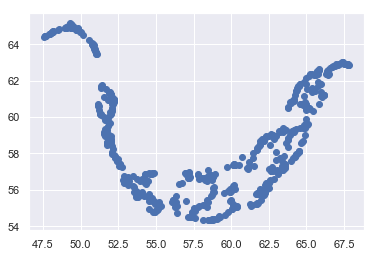

In [44]:
'''Visualize UMAP projection'''
reducer = umap.UMAP(n_neighbors=15,min_dist=0.1,n_components=2,
                    metric=metric,random_state=random_state)
embedding = reducer.fit_transform(data)
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.show()

Name: 
Type: Graph
Number of nodes: 555
Number of edges: 13483
Average degree:  48.5874


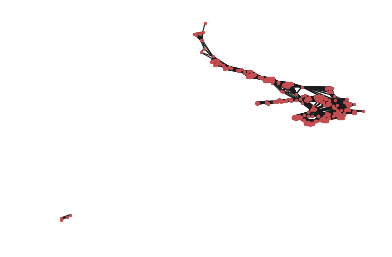

In [45]:
'''Build the network'''
net = km.to_networkx(graph)
print nx.info(net)
spring_pos = nx.spring_layout(net)

A = nx.adjacency_matrix(net)

'''Create network layout for visualizations'''
plt.figure()
plt.axis("off")
nx.draw_networkx(net, pos = spring_pos, with_labels = False, node_size = 5)

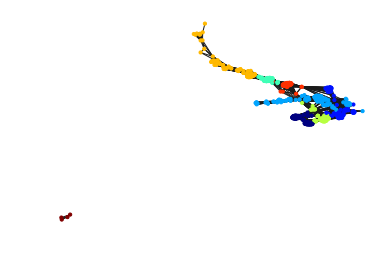

In [46]:
'''Partition the network'''
parts = best_partition(net)
values = [parts.get(node) for node in net.nodes()]

'''Create network layout for visualizations'''
plt.figure()
plt.axis("off")
nx.draw_networkx(net, pos = spring_pos, cmap = plt.get_cmap("jet"), 
                 node_color = values, node_size = 10, with_labels = False)

In [47]:
'''Get the length of the connected components'''
[len(c) for c in sorted(nx.connected_components(net), key=len, reverse=True)]

[551, 4]

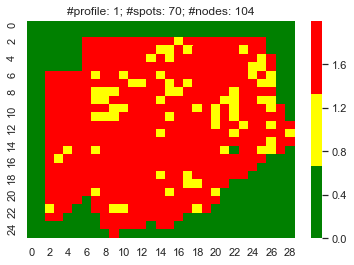

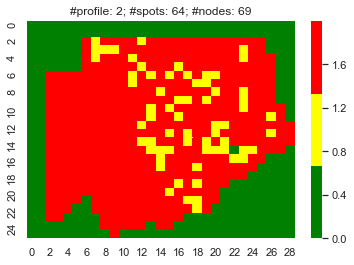

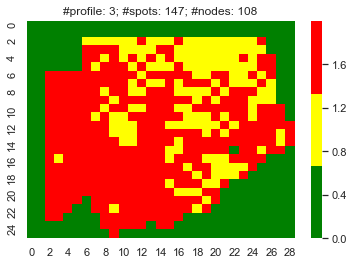

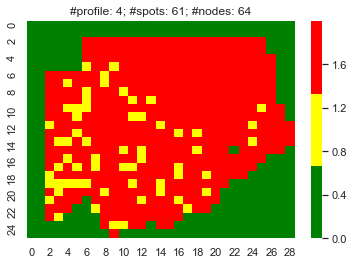

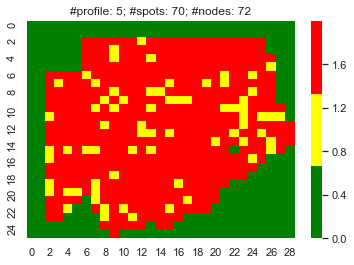

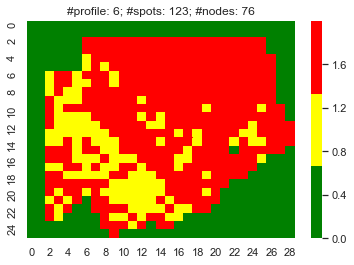

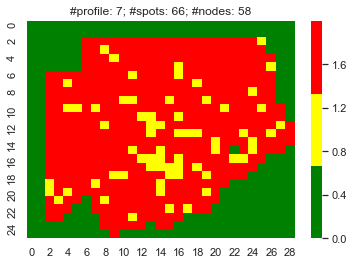

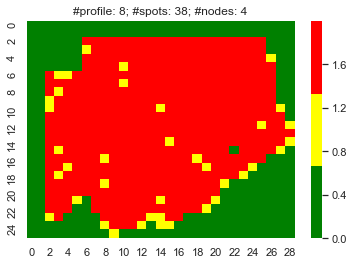

In [48]:
'''Get all the nodes in a module'''
groups = []
for value in set(parts.values()):
    value_keys = [node for node in parts.keys() if value == parts[node]]
    groups.append(value_keys) 

'''Get the entire space-profile'''
summa = dfnorm.sum(axis=0) # sum over all genes (to get 1!!!)
spatialCoord = [w.split('x') for w in list(summa.index.values)]
spatialCoord = [map(int,pairs) for pairs in spatialCoord]
i = [l[0] for l in spatialCoord]
j = [l[1] for l in spatialCoord]
maxi = max(i)+1
maxj = max(j)+1
data = summa.values
mat_global = coo_matrix((data, (i, j)), [maxi, maxj]).todense()

'''Plot the spatial projection of the modules'''
ind = 0 
for group in range(len(groups)):

    spots = [graph['nodes'][node] for node in groups[group]]
    l = list(set([item for sublist in spots for item in sublist]))
    
    newdf = dfnorm.transpose().iloc[l,:].transpose()
    summa = newdf.sum(axis=0)

    spatialCoord = [w.split('x') for w in list(summa.index.values)]
    spatialCoord = [map(int,pairs) for pairs in spatialCoord]

    i = [s[0] for s in spatialCoord]
    j = [s[1] for s in spatialCoord]

    if len(i) > 0:
        ind += 1
        plt.figure()
        mat = coo_matrix((summa.values, (i, j)), [maxi, maxj]).todense()
        mat = 2*mat_global - mat
        cmap = sns.color_palette("husl", 3)
        sns.heatmap(mat,cmap=ListedColormap(['green', 'yellow', 'red']), annot=False)
        plt.title("#profile: "+str(ind)+"; #spots: "+str(len(l))+"; #nodes: "+str(len(spots)))

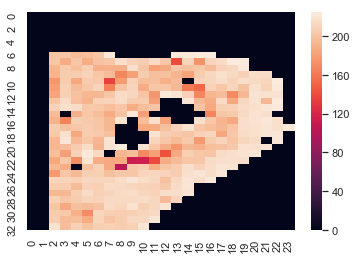

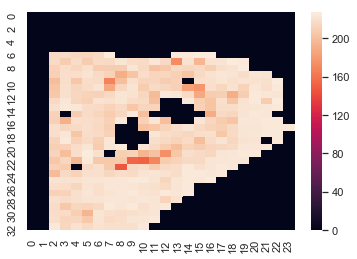

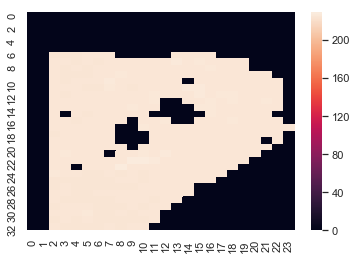

In [10]:
'''Plot spatial distribution of RC for a given gene'''
for gene in ["SPON1 ","TFF3 ","SPINK1 "]: # leave a space to make unique the name
    getGene = df[df.index.str.contains(gene)==True].transpose()

    spatialCoord = [w.split('x') for w in list(getGene.index.values)]
    spatialCoord = [map(int,pairs) for pairs in spatialCoord]

    i = [s[0] for s in spatialCoord]
    j = [s[1] for s in spatialCoord]

    plt.figure()
    mat = coo_matrix((getGene.values.ravel(), (i, j)), [maxi, maxj]).todense()
    sns.heatmap(mat, annot=False)

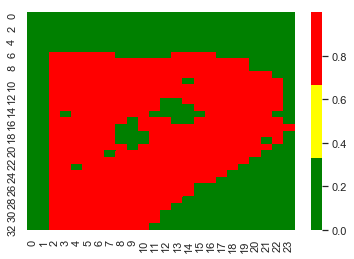

In [11]:
sns.heatmap(mat_global,cmap=ListedColormap(['green', 'yellow', 'red']), annot=False)

In [12]:
outfile = './matglobalep11.npz'
np.savez(outfile, mat_global)